In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
b     = 1               # ルーズなb
m     = 0.04            # E→S
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

In [3]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [4]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [5]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [6]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Positive']),np.max(df_['TP']),np.max(df_['FP']),
            np.max(df_['Hospitalised']),np.max(df_['Sh']),np.max(df_['Eh']),np.max(df_['Ih']),
            np.max(df_['Dead']),np.max(df_['Dh']),np.max(df_['Do'])
           ]

# 活性化関数あり版（cap=0.1）

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


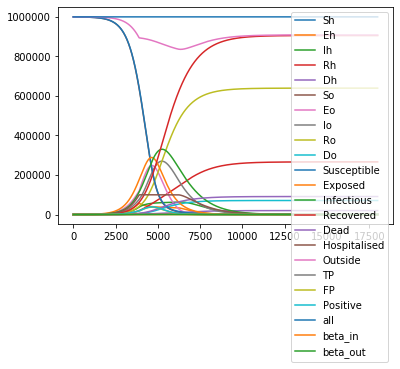

In [7]:
tSEIRD_matrix(0.7,0.7,0.5,0.01).plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


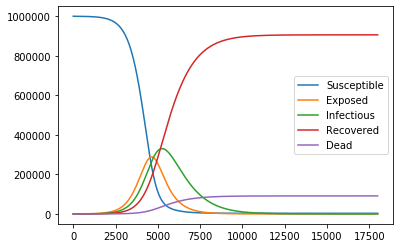

In [8]:
tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Susceptible','Exposed','Infectious','Recovered','Dead']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


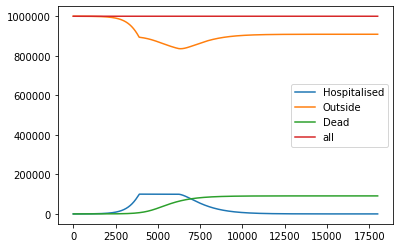

In [9]:
tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Hospitalised','Outside','Dead','all']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


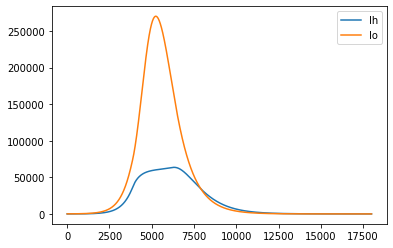

In [10]:
tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Ih','Io']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


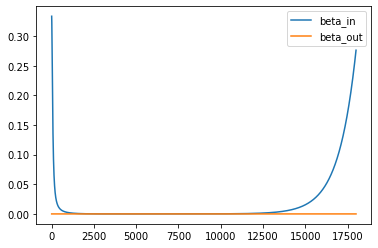

In [11]:
tSEIRD_matrix(0.7,0.7,0.5,0.01)[['beta_in','beta_out']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


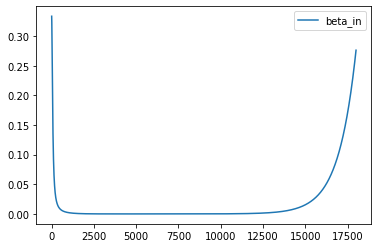

In [12]:
tSEIRD_matrix(0.7,0.7,0.5,0.01)[['beta_in']].plot()

In [13]:
tSEIRD_max(0.7,0.7,0.5,0.01,1)

[26339.183262809347,
 1264.1820821304293,
 25300.92480698847,
 276520.9803859628,
 10322.560496779932,
 125574.04859580308,
 159069.39853395167,
 83955.50970591878,
 36009.80771979114,
 47945.70198612765]

In [14]:
tSEIRD_max(0.9,0.9,0.5,0.01,1)

[14727.75528338521,
 2379.0991588258516,
 12796.361147641412,
 147743.60330861522,
 4855.840298803458,
 62375.02394252446,
 91487.75277348368,
 90574.90930462074,
 20977.2852626689,
 69597.62404195184]

## 検査特性を固定してsurfaceplot

In [15]:
v = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v.append(tSEIRD_max(0.7,0.7,i,j))

pos_test_fix   = np.array(v)[:, 0].reshape((101,101))
# pos_test_fix breakdown
TP_test_fix = np.array(v)[:,1].reshape((101,101))
FP_test_fix = np.array(v)[:,2].reshape((101,101))

hosp_test_fix  = np.array(v)[:, 3].reshape((101,101))
# hosp_test_fix breakdown
Sh_test_fix = np.array(v)[:,4].reshape((101,101))
Eh_test_fix = np.array(v)[:,5].reshape((101,101))
Ih_test_fix = np.array(v)[:,6].reshape((101,101))

death_test_fix = np.array(v)[:, 7].reshape((101,101))
# death_test_fix breakdown
Dh_test_fix = np.array(v)[:,8].reshape((101,101))
Do_test_fix = np.array(v)[:,9].reshape((101,101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# v_を保存

np.savetxt('v.csv',v,delimiter=',')

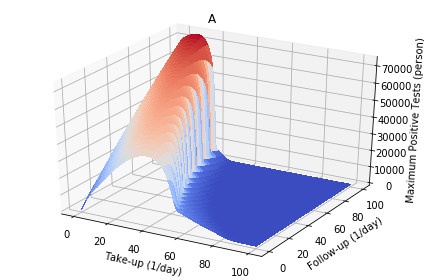

In [17]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_test_fix #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_test_fix), np.max(pos_test_fix)))
#ax.set_zlim((np.min(positive_test_fix)/1000, np.max(positive_test_fix)/1000))

ax.set_xlabel('Take-up (1/day)')
ax.set_ylabel('Follow-up (1/day)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

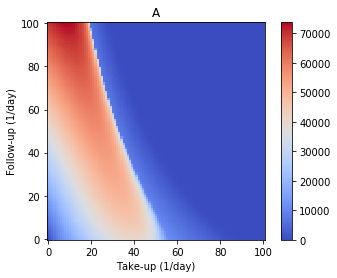

In [18]:
plt.figure()
plt.title('A')#pos_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(pos_test_fix,interpolation='nearest',vmin=np.min(pos_test_fix),vmax=np.max(pos_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

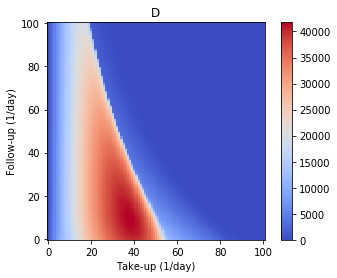

In [19]:
plt.figure()
plt.title('D')#TP (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(TP_test_fix,interpolation='nearest',vmin=np.min(TP_test_fix),vmax=np.max(TP_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

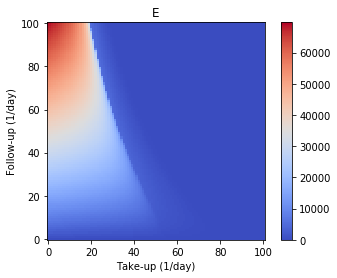

In [20]:
plt.figure()
plt.title('E')#TP (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(FP_test_fix,interpolation='nearest',vmin=np.min(FP_test_fix),vmax=np.max(FP_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

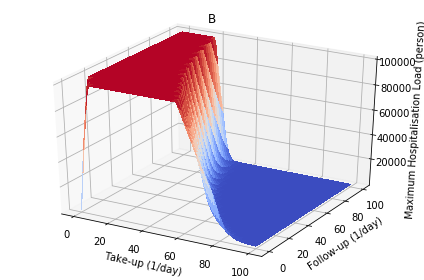

In [21]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_test_fix#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_test_fix),np.max(hosp_test_fix)))
#ax.set_zlim((np.min(hospitalised_test_fix)/1000,np.max(hospitalised_test_fix)/1000))

ax.set_xlabel('Take-up (1/day)')
ax.set_ylabel('Follow-up (1/day)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

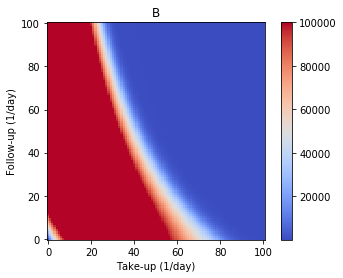

In [34]:
plt.figure()
plt.title('B')#hosp_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(hosp_test_fix,interpolation='nearest',vmin=np.min(hosp_test_fix),vmax=np.max(hosp_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

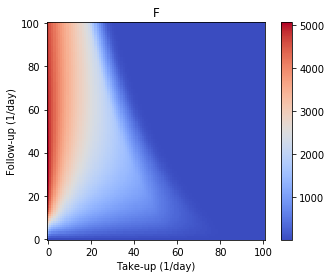

In [33]:
plt.figure()
plt.title('F')#TP (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(Sh_test_fix,interpolation='nearest',vmin=np.min(Sh_test_fix),vmax=np.max(Sh_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

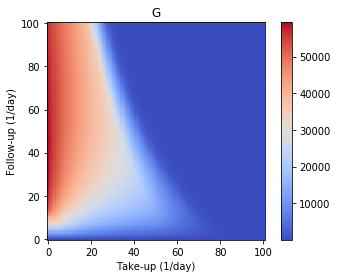

In [32]:
plt.figure()
plt.title('G')#TP (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(Eh_test_fix,interpolation='nearest',vmin=np.min(Eh_test_fix),vmax=np.max(Eh_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

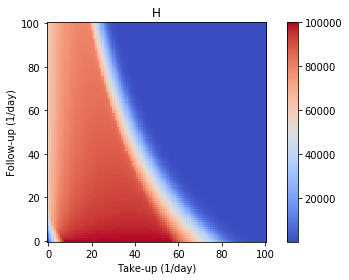

In [25]:
plt.figure()
plt.title('H')#TP (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(Ih_test_fix,interpolation='nearest',vmin=np.min(Ih_test_fix),vmax=np.max(Ih_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

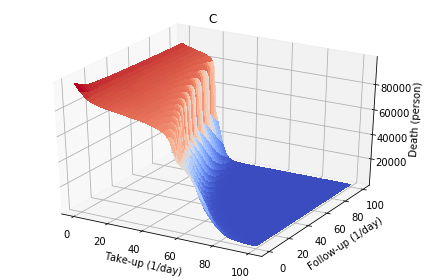

In [26]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_test_fix), np.max(death_test_fix)))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Take-up (1/day)')
ax.set_ylabel('Follow-up (1/day)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

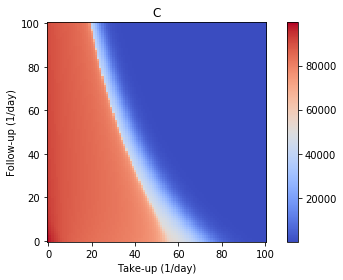

In [27]:
plt.figure()
plt.title('C')#death_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(death_test_fix,interpolation='nearest',vmin=np.min(death_test_fix),vmax=np.max(death_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

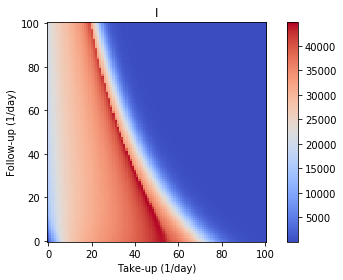

In [28]:
plt.figure()
plt.title('I')#TP (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(Dh_test_fix,interpolation='nearest',vmin=np.min(Dh_test_fix),vmax=np.max(Dh_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

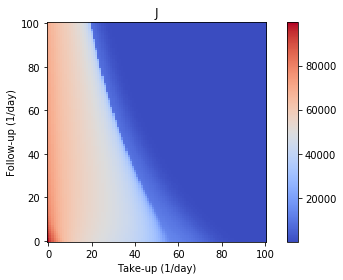

In [29]:
plt.figure()
plt.title('J')#TP (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(Do_test_fix,interpolation='nearest',vmin=np.min(Do_test_fix),vmax=np.max(Do_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [29]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t.append(tSEIRD_max(i,j,0.5,0.01))

pos_visit_fix   = np.array(t)[:, 0].reshape((101,101))
# pos_visit_fix breakdown
TP_visit_fix = np.array(t)[:,1].reshape((101,101))
FP_visit_fix = np.array(t)[:,2].reshape((101,101))

hosp_visit_fix  = np.array(t)[:, 3].reshape((101,101))
# hosp_v_fix breakdown
Sh_visit_fix = np.array(t)[:,4].reshape((101,101))
Eh_visit_fix = np.array(t)[:,5].reshape((101,101))
Ih_visit_fix = np.array(t)[:,6].reshape((101,101))

death_visit_fix = np.array(t)[:, 7].reshape((101,101))
# death_visit_fix breakdown
Dh_visit_fix = np.array(t)[:,8].reshape((101,101))
Do_visit_fix = np.array(t)[:,9].reshape((101,101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
# tを保存

np.savetxt('t.csv',t,delimiter=',')

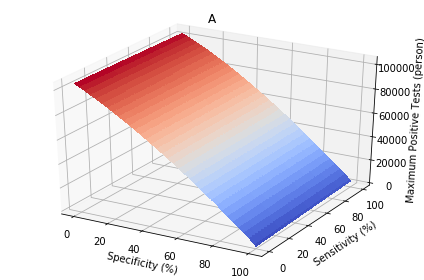

In [31]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix), np.max(pos_visit_fix)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

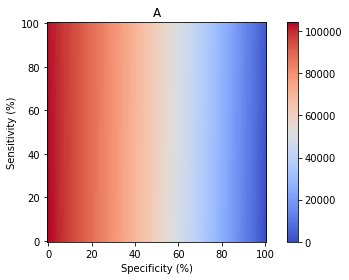

In [32]:
plt.figure()
plt.title('A')#pos_visit_fix (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(pos_visit_fix,interpolation='nearest',vmin=np.min(pos_visit_fix),vmax=np.max(pos_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

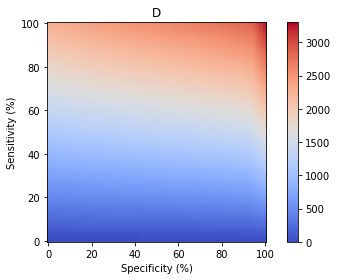

In [33]:
plt.figure()
plt.title('D')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(TP_visit_fix,interpolation='nearest',vmin=np.min(TP_visit_fix),vmax=np.max(TP_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

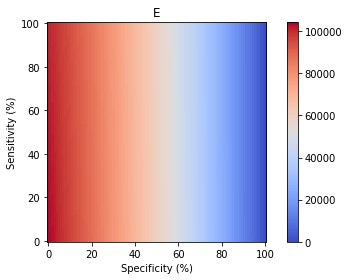

In [34]:
plt.figure()
plt.title('E')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(FP_visit_fix,interpolation='nearest',vmin=np.min(FP_visit_fix),vmax=np.max(FP_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

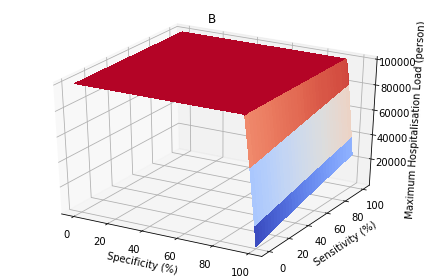

In [35]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix),np.max(hosp_visit_fix)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

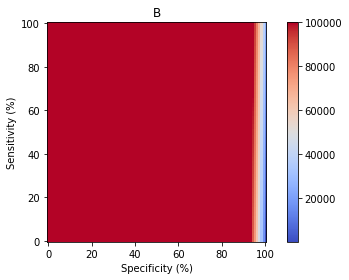

In [36]:
plt.figure()
plt.title('B')#hosp_visit_fix (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(hosp_visit_fix,interpolation='nearest',vmin=np.min(hosp_visit_fix),vmax=np.max(hosp_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

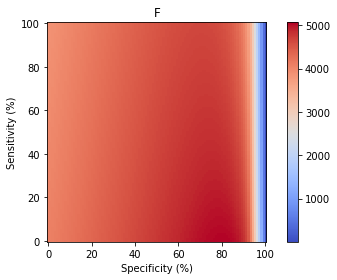

In [37]:
plt.figure()
plt.title('F')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Sh_visit_fix,interpolation='nearest',vmin=np.min(Sh_visit_fix),vmax=np.max(Sh_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

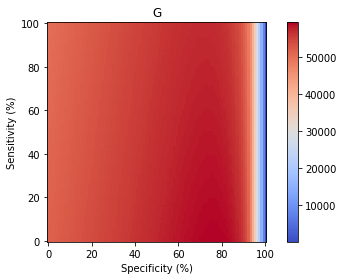

In [38]:
plt.figure()
plt.title('G')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Eh_visit_fix,interpolation='nearest',vmin=np.min(Eh_visit_fix),vmax=np.max(Eh_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

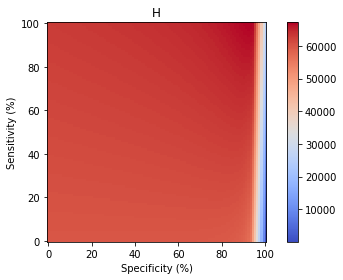

In [39]:
plt.figure()
plt.title('H')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Ih_visit_fix,interpolation='nearest',vmin=np.min(Ih_visit_fix),vmax=np.max(Ih_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

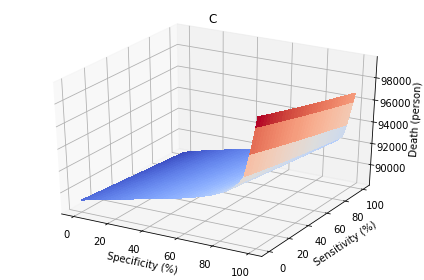

In [40]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix), np.max(death_visit_fix)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

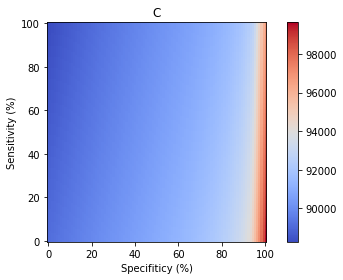

In [41]:
plt.figure()
plt.title('C')#death_visit_fix (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(death_visit_fix,interpolation='nearest',vmin=np.min(death_visit_fix),vmax=np.max(death_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

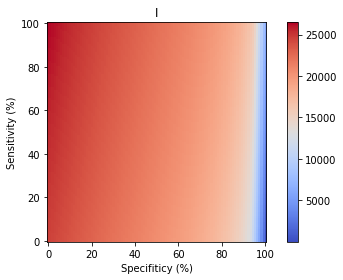

In [42]:
plt.figure()
plt.title('I')#TP (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Dh_visit_fix,interpolation='nearest',vmin=np.min(Dh_visit_fix),vmax=np.max(Dh_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

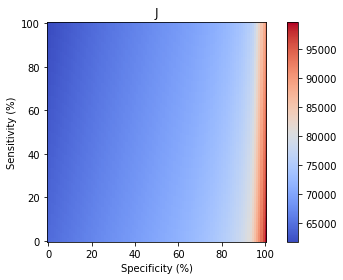

In [43]:
plt.figure()
plt.title('J')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Do_visit_fix,interpolation='nearest',vmin=np.min(Do_visit_fix),vmax=np.max(Do_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を映え重視で固定

In [44]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_07 = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t_07.append(tSEIRD_max(i,j,0.7,0.7))

pos_visit_fix_07   = np.array(t_07)[:, 0].reshape((101,101))
# pos_visit_fix breakdown
TP_visit_fix_07 = np.array(t_07)[:,1].reshape((101,101))
FP_visit_fix_07 = np.array(t_07)[:,2].reshape((101,101))

hosp_visit_fix_07  = np.array(t_07)[:, 3].reshape((101,101))
# hosp_v_fix breakdown
Sh_visit_fix_07 = np.array(t_07)[:,4].reshape((101,101))
Eh_visit_fix_07 = np.array(t_07)[:,5].reshape((101,101))
Ih_visit_fix_07 = np.array(t_07)[:,6].reshape((101,101))

death_visit_fix_07 = np.array(t_07)[:, 7].reshape((101,101))
# death_visit_fix breakdown
Dh_visit_fix_07 = np.array(t_07)[:,8].reshape((101,101))
Do_visit_fix_07 = np.array(t_07)[:,9].reshape((101,101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
# tを保存

np.savetxt('t_07.csv',t_07,delimiter=',')

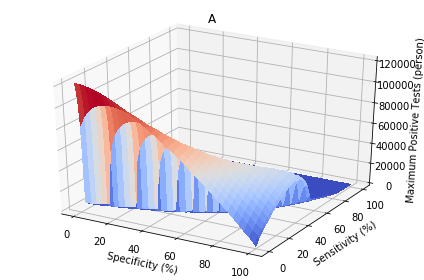

In [46]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix_07 #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix_07), np.max(pos_visit_fix_07)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

#plt.gca().invert_yaxis()
# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

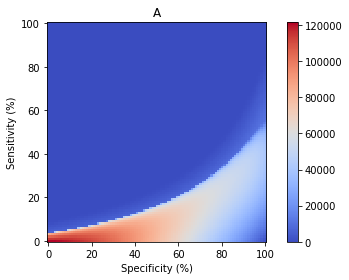

In [47]:
plt.figure()
plt.title('A')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(pos_visit_fix_07,interpolation='nearest',vmin=np.min(pos_visit_fix_07),vmax=np.max(pos_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

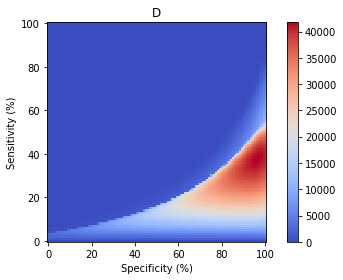

In [48]:
plt.figure()
plt.title('D')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(TP_visit_fix_07,interpolation='nearest',vmin=np.min(TP_visit_fix_07),vmax=np.max(TP_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

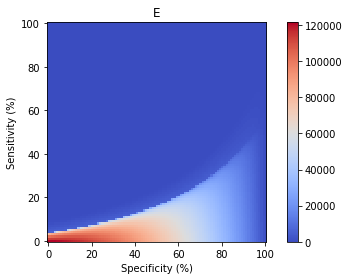

In [49]:
plt.figure()
plt.title('E')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(FP_visit_fix_07,interpolation='nearest',vmin=np.min(FP_visit_fix_07),vmax=np.max(FP_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

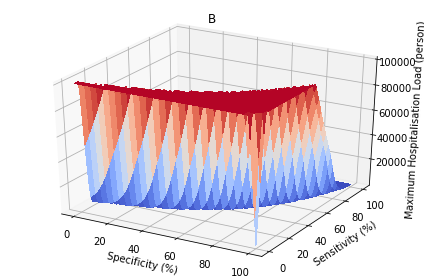

In [50]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix_07#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix_07),np.max(hosp_visit_fix_07)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

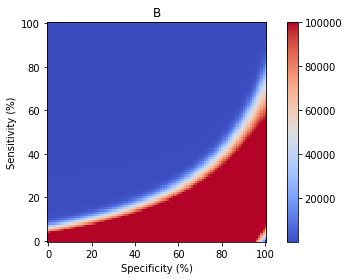

In [51]:
plt.figure()
plt.title('B')#hosp_visit_fix_07 (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(hosp_visit_fix_07,interpolation='nearest',vmin=np.min(hosp_visit_fix_07),vmax=np.max(hosp_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

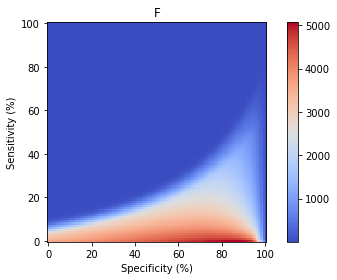

In [52]:
plt.figure()
plt.title('F')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Sh_visit_fix_07,interpolation='nearest',vmin=np.min(Sh_visit_fix_07),vmax=np.max(Sh_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

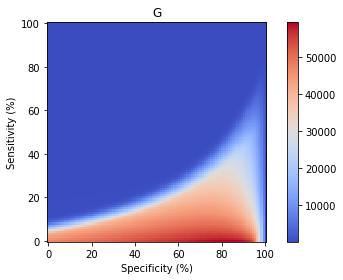

In [53]:
plt.figure()
plt.title('G')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Eh_visit_fix_07,interpolation='nearest',vmin=np.min(Eh_visit_fix_07),vmax=np.max(Eh_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

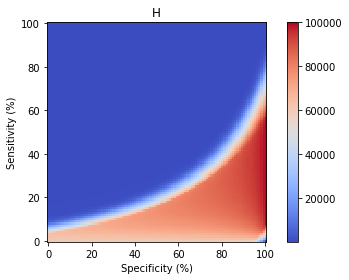

In [54]:
plt.figure()
plt.title('H')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Ih_visit_fix_07,interpolation='nearest',vmin=np.min(Ih_visit_fix_07),vmax=np.max(Ih_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

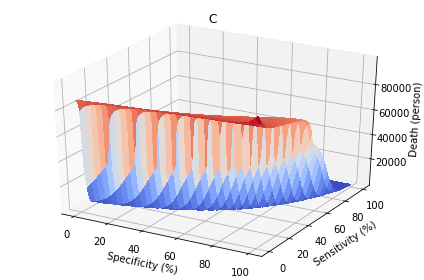

In [55]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix_07#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix_07), np.max(death_visit_fix_07)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

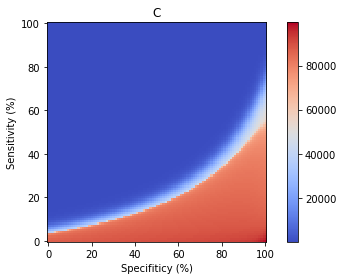

In [56]:
plt.figure()
plt.title('C')#death_visit_fix_07 (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(death_visit_fix_07,interpolation='nearest',vmin=np.min(death_visit_fix_07),vmax=np.max(death_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

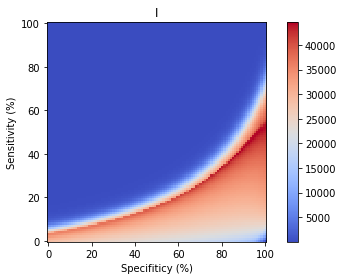

In [57]:
plt.figure()
plt.title('I')#TP (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Dh_visit_fix_07,interpolation='nearest',vmin=np.min(Dh_visit_fix_07),vmax=np.max(Dh_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

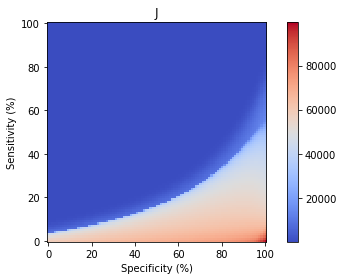

In [58]:
plt.figure()
plt.title('J')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Do_visit_fix_07,interpolation='nearest',vmin=np.min(Do_visit_fix_07),vmax=np.max(Do_visit_fix_07),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# 活性化関数なし版（cap=1）

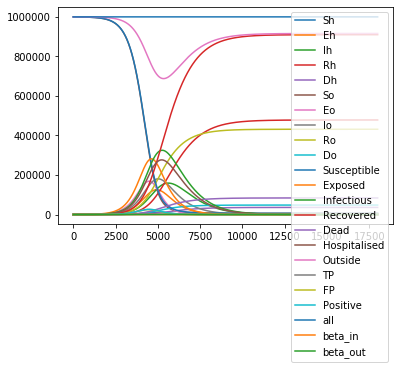

In [59]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,1).plot()

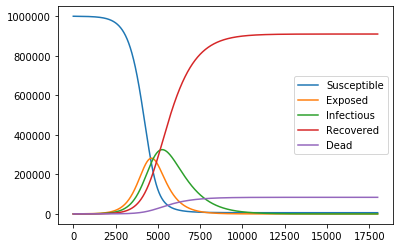

In [60]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['Susceptible','Exposed','Infectious','Recovered','Dead']].plot()

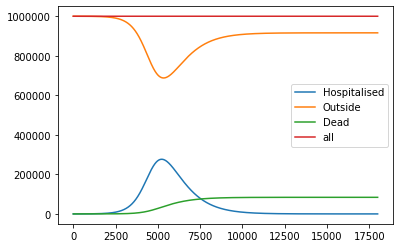

In [61]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['Hospitalised','Outside','Dead','all']].plot()

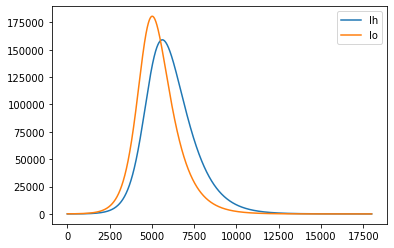

In [62]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['Ih','Io']].plot()

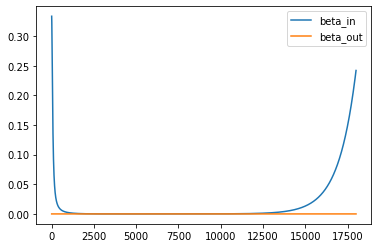

In [63]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['beta_in','beta_out']].plot()

In [64]:
tSEIRD_max(0.7,0.7,0.5,0.01,1)

[26339.183262809347,
 1264.1820821304293,
 25300.92480698847,
 276520.9803859628,
 10322.560496779932,
 125574.04859580308,
 159069.39853395167,
 83955.50970591878,
 36009.80771979114,
 47945.70198612765]

In [65]:
tSEIRD_max(0.9,0.9,0.5,0.01,1)

[14727.75528338521,
 2379.0991588258516,
 12796.361147641412,
 147743.60330861522,
 4855.840298803458,
 62375.02394252446,
 91487.75277348368,
 90574.90930462074,
 20977.2852626689,
 69597.62404195184]

## 検査特性を固定してsurfaceplot

In [66]:
v_ = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_ = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_.append(tSEIRD_max(0.7,0.7,i,j,1))

pos_test_fix_   = np.array(v_)[:, 0].reshape((101,101))
# pos_test_fix breakdown
TP_test_fix_ = np.array(v_)[:,1].reshape((101,101))
FP_test_fix_ = np.array(v_)[:,2].reshape((101,101))

hosp_test_fix_  = np.array(v_)[:, 3].reshape((101,101))
# hosp_test_fix breakdown
Sh_test_fix_ = np.array(v_)[:,4].reshape((101,101))
Eh_test_fix_ = np.array(v_)[:,5].reshape((101,101))
Ih_test_fix_ = np.array(v_)[:,6].reshape((101,101))

death_test_fix_ = np.array(v_)[:, 7].reshape((101,101))
# death_test_fix breakdown
Dh_test_fix_ = np.array(v_)[:,8].reshape((101,101))
Do_test_fix_ = np.array(v_)[:,9].reshape((101,101))

In [67]:
# v_を保存

np.savetxt('v_.csv',v_,delimiter=',')

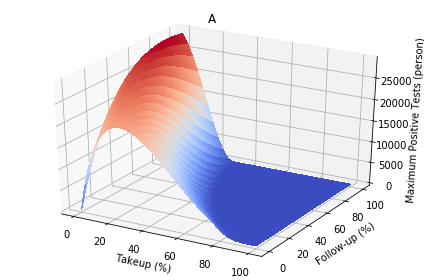

In [68]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_test_fix_ #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_test_fix_), np.max(pos_test_fix_)))
#ax.set_zlim((np.min(positive_test_fix)/1000, np.max(positive_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

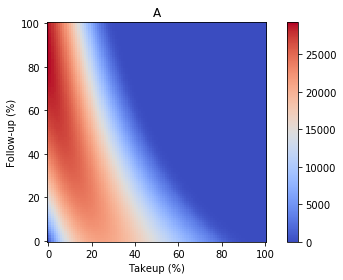

In [69]:
plt.figure()
plt.title('A')#pos_test_fix_ (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(pos_test_fix_,interpolation='nearest',vmin=np.min(pos_test_fix_),vmax=np.max(pos_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

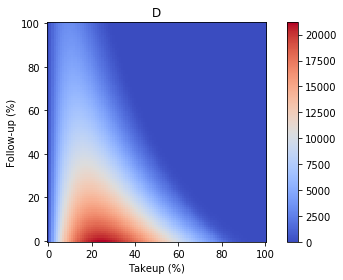

In [70]:
plt.figure()
plt.title('D')#TP (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(TP_test_fix_,interpolation='nearest',vmin=np.min(TP_test_fix_),vmax=np.max(TP_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

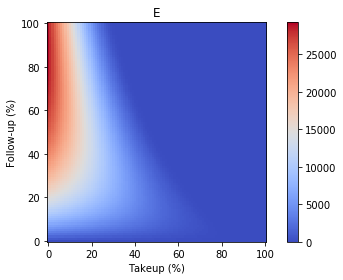

In [71]:
plt.figure()
plt.title('E')#TP (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(FP_test_fix_,interpolation='nearest',vmin=np.min(FP_test_fix_),vmax=np.max(FP_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

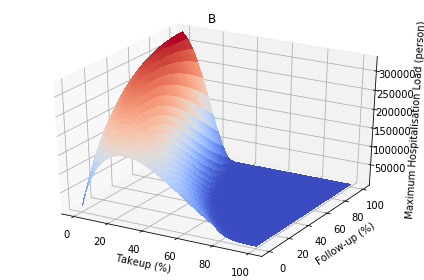

In [72]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_test_fix_#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_test_fix_),np.max(hosp_test_fix_)))
#ax.set_zlim((np.min(hospitalised_test_fix)/1000,np.max(hospitalised_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

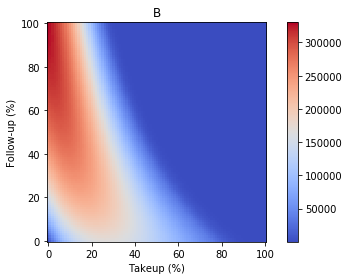

In [73]:
plt.figure()
plt.title('B')#hosp_test_fix_ (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(hosp_test_fix_,interpolation='nearest',vmin=np.min(hosp_test_fix_),vmax=np.max(hosp_test_fix_),cmap='coolwarm')
plt.colorbar()

plt.gca().invert_yaxis()
#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

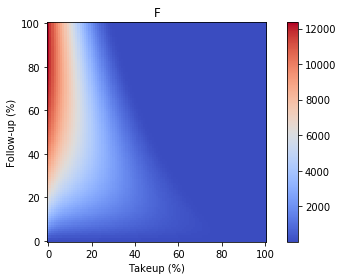

In [74]:
plt.figure()
plt.title('F')#TP (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(Sh_test_fix_,interpolation='nearest',vmin=np.min(Sh_test_fix_),vmax=np.max(Sh_test_fix_),cmap='coolwarm')
plt.colorbar()

plt.gca().invert_yaxis()
#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

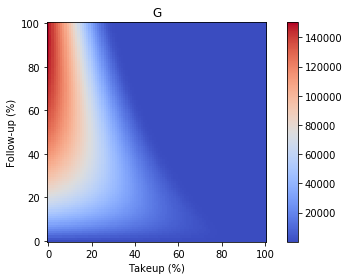

In [75]:
plt.figure()
plt.title('G')#TP (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(Eh_test_fix_,interpolation='nearest',vmin=np.min(Eh_test_fix_),vmax=np.max(Eh_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

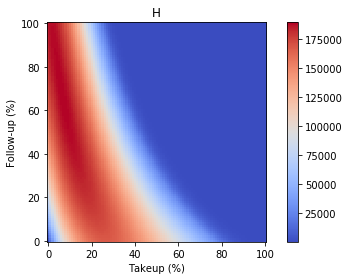

In [76]:
plt.figure()
plt.title('H')#TP (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(Ih_test_fix_,interpolation='nearest',vmin=np.min(Ih_test_fix_),vmax=np.max(Ih_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

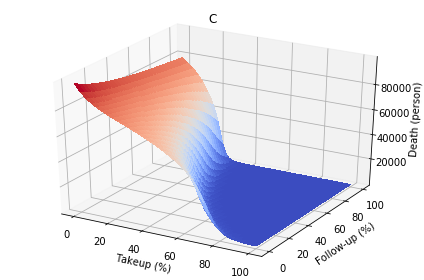

In [77]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_test_fix_), np.max(death_test_fix_)))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

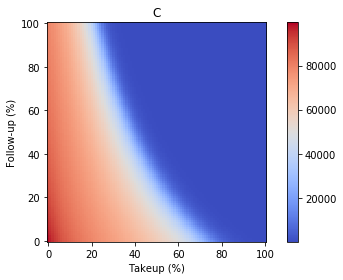

In [78]:
plt.figure()
plt.title('C')#death_test_fix_ (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(death_test_fix_,interpolation='nearest',vmin=np.min(death_test_fix_),vmax=np.max(death_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

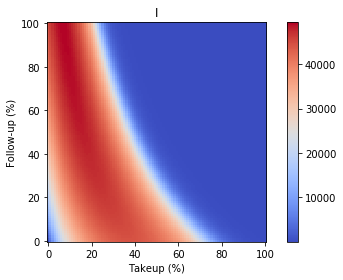

In [79]:
plt.figure()
plt.title('I')#TP (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(Dh_test_fix_,interpolation='nearest',vmin=np.min(Dh_test_fix_),vmax=np.max(Dh_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

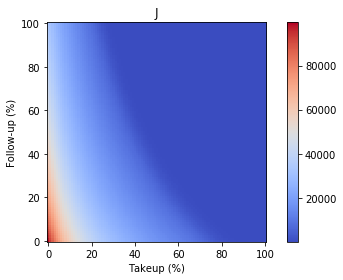

In [80]:
plt.figure()
plt.title('J')#TP (person)')
plt.xlabel('Takeup (%)')
plt.ylabel('Follow-up (%)')
plt.imshow(Do_test_fix_,interpolation='nearest',vmin=np.min(Do_test_fix_),vmax=np.max(Do_test_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [81]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_ = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t_.append(tSEIRD_max(i,j,0.5,0.01,1))

pos_visit_fix_   = np.array(t_)[:, 0].reshape((101,101))
# pos_visit_fix breakdown
TP_visit_fix_ = np.array(t_)[:,1].reshape((101,101))
FP_visit_fix_ = np.array(t_)[:,2].reshape((101,101))

hosp_visit_fix_  = np.array(t_)[:, 3].reshape((101,101))
# hosp_v_fix breakdown
Sh_visit_fix_ = np.array(t_)[:,4].reshape((101,101))
Eh_visit_fix_ = np.array(t_)[:,5].reshape((101,101))
Ih_visit_fix_ = np.array(t_)[:,6].reshape((101,101))

death_visit_fix_ = np.array(t_)[:, 7].reshape((101,101))
# death_visit_fix breakdown
Dh_visit_fix_ = np.array(t_)[:,8].reshape((101,101))
Do_visit_fix_ = np.array(t_)[:,9].reshape((101,101))

In [82]:
# tを保存

np.savetxt('t_.csv',t_,delimiter=',')

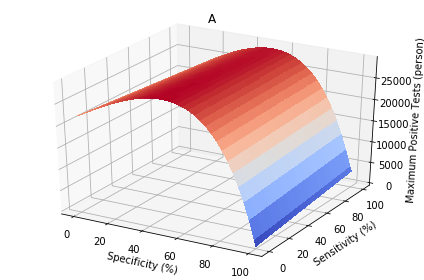

In [83]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix_ #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix_), np.max(pos_visit_fix_)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

#plt.gca().invert_yaxis()
# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

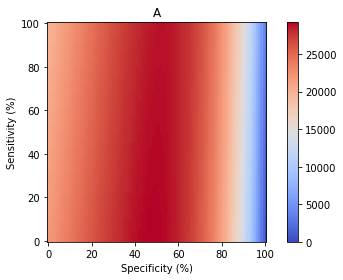

In [84]:
plt.figure()
plt.title('A')#pos_visit_fix_ (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(pos_visit_fix_,interpolation='nearest',vmin=np.min(pos_visit_fix_),vmax=np.max(pos_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

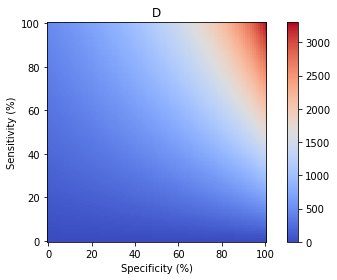

In [85]:
plt.figure()
plt.title('D')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(TP_visit_fix_,interpolation='nearest',vmin=np.min(TP_visit_fix_),vmax=np.max(TP_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

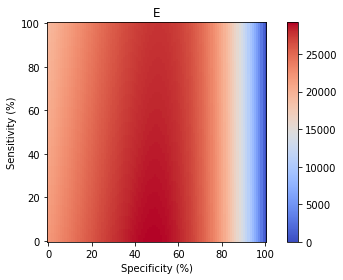

In [86]:
plt.figure()
plt.title('E')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(FP_visit_fix_,interpolation='nearest',vmin=np.min(FP_visit_fix_),vmax=np.max(FP_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

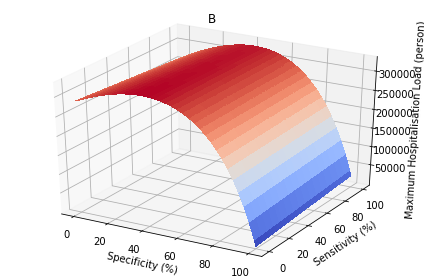

In [87]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix_#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix_),np.max(hosp_visit_fix_)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

#plt.gca().invert_yaxis()
# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

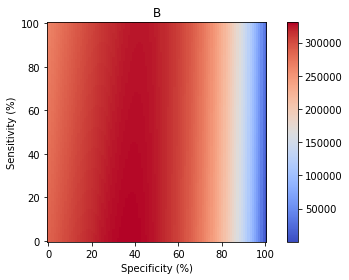

In [88]:
plt.figure()
plt.title('B')#hosp_visit_fix_ (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(hosp_visit_fix_,interpolation='nearest',vmin=np.min(hosp_visit_fix_),vmax=np.max(hosp_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

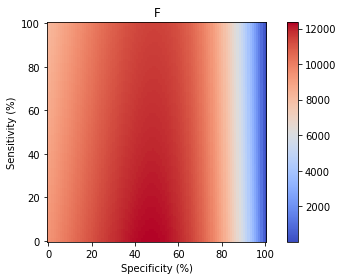

In [89]:
plt.figure()
plt.title('F')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Sh_visit_fix_,interpolation='nearest',vmin=np.min(Sh_visit_fix_),vmax=np.max(Sh_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

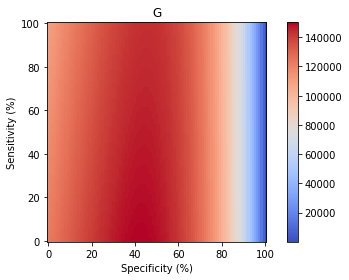

In [90]:
plt.figure()
plt.title('G')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Eh_visit_fix_,interpolation='nearest',vmin=np.min(Eh_visit_fix_),vmax=np.max(Eh_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

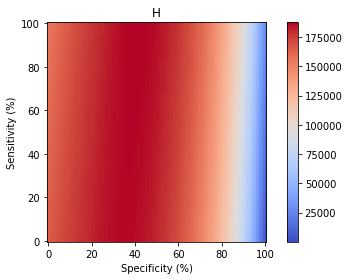

In [91]:
plt.figure()
plt.title('H')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Ih_visit_fix_,interpolation='nearest',vmin=np.min(Ih_visit_fix_),vmax=np.max(Ih_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

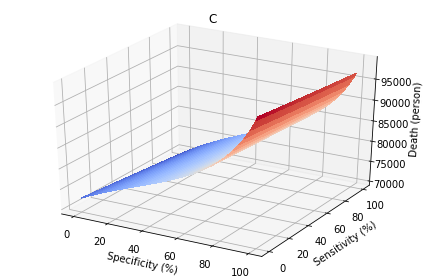

In [92]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix_#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix_), np.max(death_visit_fix_)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

#plt.gca().invert_yaxis()
# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

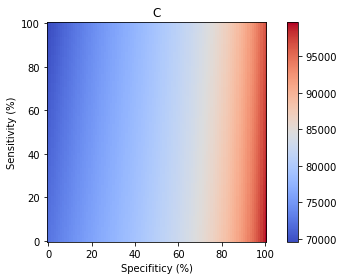

In [93]:
plt.figure()
plt.title('C')#death_visit_fix_ (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(death_visit_fix_,interpolation='nearest',vmin=np.min(death_visit_fix_),vmax=np.max(death_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

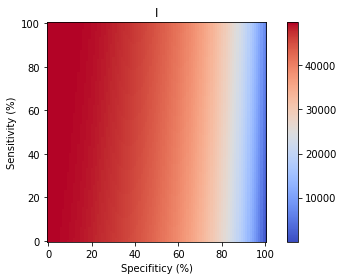

In [94]:
plt.figure()
plt.title('I')#TP (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Dh_visit_fix_,interpolation='nearest',vmin=np.min(Dh_visit_fix_),vmax=np.max(Dh_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

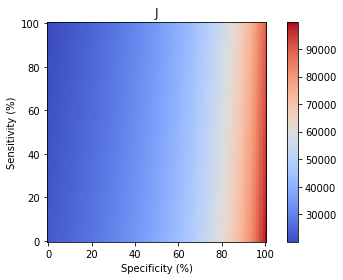

In [95]:
plt.figure()
plt.title('J')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(Do_visit_fix_,interpolation='nearest',vmin=np.min(Do_visit_fix_),vmax=np.max(Do_visit_fix_),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [96]:
from email import message
import smtplib
 

smtp_host = 'smtp.gmail.com'   # メールを送るSMTPサーバー
smtp_port = 587   # ポート番号
from_email = 'bougtoir@gmail.com'   # 送信元のメールアドレス(Gmeilアドレス)
to_email = 'bougtoir@gmail.com'   # 送信先のメールアドレス
username = 'bougtoir@gmail.com'   # ユーザーネームはGoogleアカウント（Gmailアドレス）
password = 'asalxwpzjstooggg'   # Googleアカウントのパスワード
 
# 送信メールを作成する
msg = message.EmailMessage()   # メッセージオブジェクトを作成
msg.set_content('結果出たよ！')   # メール本文
msg['Subject'] = 'note from python'   # メールのタイトル（件名）
msg['From'] = from_email   # メール送信元
msg['To'] = to_email   # メール送信先
 
# メールサーバーへアクセスする
server = smtplib.SMTP(smtp_host, smtp_port)
server.ehlo()
server.starttls()
server.ehlo()
server.login(username, password)
server.send_message(msg)
server.quit()

(221, b'2.0.0 closing connection e2sm345074pgl.38 - gsmtp')

In [97]:
tSEIRD_max(1,1,1,1)

[97.0,
 97.0,
 0.0,
 90.03587152429346,
 1.0,
 1.405516302102458,
 89.26326487160355,
 26.05848469015929,
 22.82705691541807,
 3.231427774741222]

# 最大値インデックス探索

In [98]:
np.unravel_index(np.argmax(pos_test_fix), pos_test_fix.shape)

(100, 9)

In [99]:
pos_test_fix_[100,9]

20721.226895637916

In [100]:
np.unravel_index(np.argmax(hosp_test_fix), hosp_test_fix.shape)

(100, 2)

In [101]:
hosp_test_fix[100,2]

100002.39168409597

In [102]:
np.unravel_index(np.argmax(death_test_fix), death_test_fix.shape)

(0, 0)

In [103]:
death_test_fix[0,0]

99634.59477295486

In [104]:
np.unravel_index(np.argmax(pos_visit_fix), pos_visit_fix.shape)

(0, 0)

In [105]:
pos_visit_fix[0,0]

104184.2063897551

In [106]:
np.unravel_index(np.argmax(hosp_visit_fix), hosp_visit_fix.shape)

(0, 0)

In [107]:
hosp_visit_fix[0,0]

100002.8033820081

In [108]:
np.unravel_index(np.argmax(death_visit_fix), death_visit_fix.shape)

(0, 100)

In [109]:
death_visit_fix[0,100]

99634.59477295486